## Simple Exponential Smoothing (SES)

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

### Dữ liệu ghi nhận doanh số xe bán ra hàng tháng ở Na Uy theo hãng từ năm 2007 đến 2017, dưới dạng chuỗi thời gian (time series).

In [ ]:

df = pd.read_csv("/content/norway_new_car_sales_by_make.csv")
df["ds"] = pd.to_datetime(df["Year"].astype(str) + "-" + df["Month"].astype(str) + "-1")
df = df[["ds", "Make", "Pct","Quantity"]]
df.head()

,ds,Make,Pct,Quantity
0,2007-01-01,Toyota,22.7,2884
1,2007-01-01,Volkswagen,19.9,2521
2,2007-01-01,Peugeot,8.1,1029
3,2007-01-01,Ford,6.9,870
4,2007-01-01,Volvo,5.5,693


In [ ]:
df.ds

,ds
0,2007-01-01
1,2007-01-01
2,2007-01-01
3,2007-01-01
4,2007-01-01
...,...
4372,2017-01-01
4373,2017-01-01
4374,2017-01-01
4375,2017-01-01


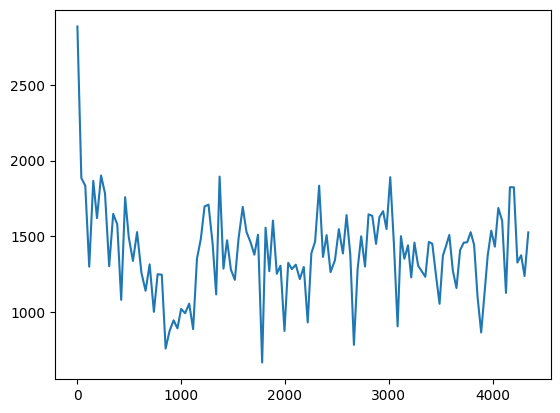

In [ ]:
plt.plot(df.query("Make == 'Toyota'").Quantity)

In [ ]:
train = df.query("Make == 'Toyota'")[["ds", "Quantity"]]
test = df.query("Make == 'Toyota' & ds >= '2015-01-01'")[["ds", "Quantity"]]

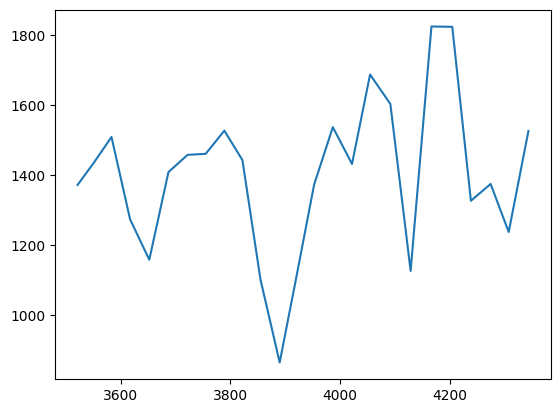

In [ ]:
plt.plot(test)

In [83]:
# Loại bỏ log
import warnings
from statsmodels.tools.sm_exceptions import EstimationWarning

# Tắt cảnh báo EstimationWarning
warnings.filterwarnings("ignore", category=EstimationWarning)

In [95]:
train = df.query("Make == 'Toyota'")[["ds", "Quantity"]]
test = df.query("Make == 'Toyota' & ds >= '2015-01-01'")[["ds", "Quantity"]]

history = train["Quantity"].tolist()
predictions = []
for new_obs in test['Quantity'].values:
    model = SimpleExpSmoothing(history)
    model_fit = model.fit(smoothing_level=0.8)
    prediction = model_fit.forecast(steps=1)
    predictions.append(prediction[0])
    history.append(new_obs)

result_data = np.array([predictions, test["Quantity"].tolist()]).T
result_df = pd.DataFrame(data=result_data, columns=["pred", "truth_values"])
result_df["ds"] = test.ds.reset_index(drop=True)
result_df.set_index("ds", inplace=True)

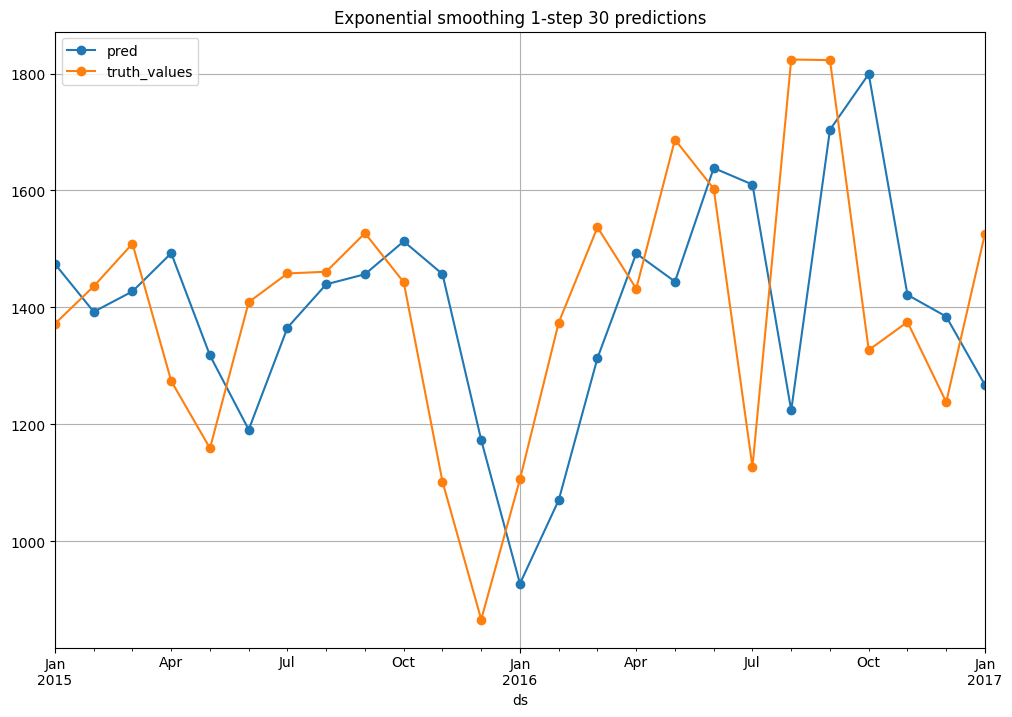

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
result_df.plot(ax=ax, marker="o")
plt.title("Exponential smoothing 1-step 30 predictions")
plt.grid()
plt.show()

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

history = train["Quantity"].tolist()
predictions = []
for new_obs in test['Quantity'].values:
    model = SimpleExpSmoothing(history)
    model_fit = model.fit(smoothing_level=0.8)
    prediction = model_fit.forecast(steps=1)
    predictions.append(prediction[0])
    history.append(new_obs)
# Xây dựng DataFrame dự đoán 1 bước
result_data = np.array([predictions, test["Quantity"].tolist()]).T
result_df = pd.DataFrame(data=result_data, columns=["pred", "truth_values"])
result_df["ds"] = test["ds"].reset_index(drop=True)
result_df.set_index("ds", inplace=True)

# Dự báo dài hạn (24 tháng)
model = SimpleExpSmoothing(history)
model_fit = model.fit(smoothing_level=0.8)

forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)

# Tạo chuỗi thời gian cho dự báo
last_date = pd.to_datetime(test["ds"].iloc[-1])
forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1),
                               periods=forecast_steps, freq="MS")

forecast_df = pd.DataFrame({
    "forecast": forecast,
    "ds": forecast_index
})
forecast_df.set_index("ds", inplace=True)

# Kết hợp cả dự đoán 1 bước và dự báo dài hạn
combined_df = pd.concat([result_df, forecast_df], axis=0)

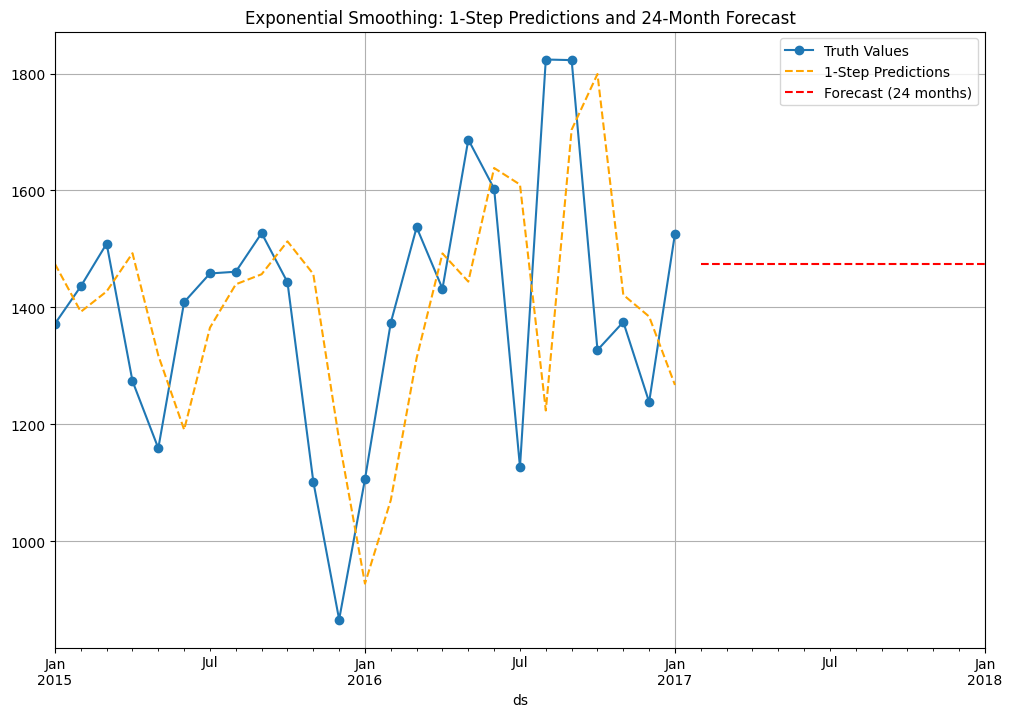

In [98]:
# Vẽ đồ thị
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
result_df["truth_values"].plot(ax=ax, marker="o", label="Truth Values")
result_df["pred"].plot(ax=ax, linestyle="--", color="orange", label="1-Step Predictions")
forecast_df["forecast"].plot(ax=ax, linestyle="--", color="red", label="Forecast (24 months)")
plt.title("Exponential Smoothing: 1-Step Predictions and 24-Month Forecast")
plt.grid()
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


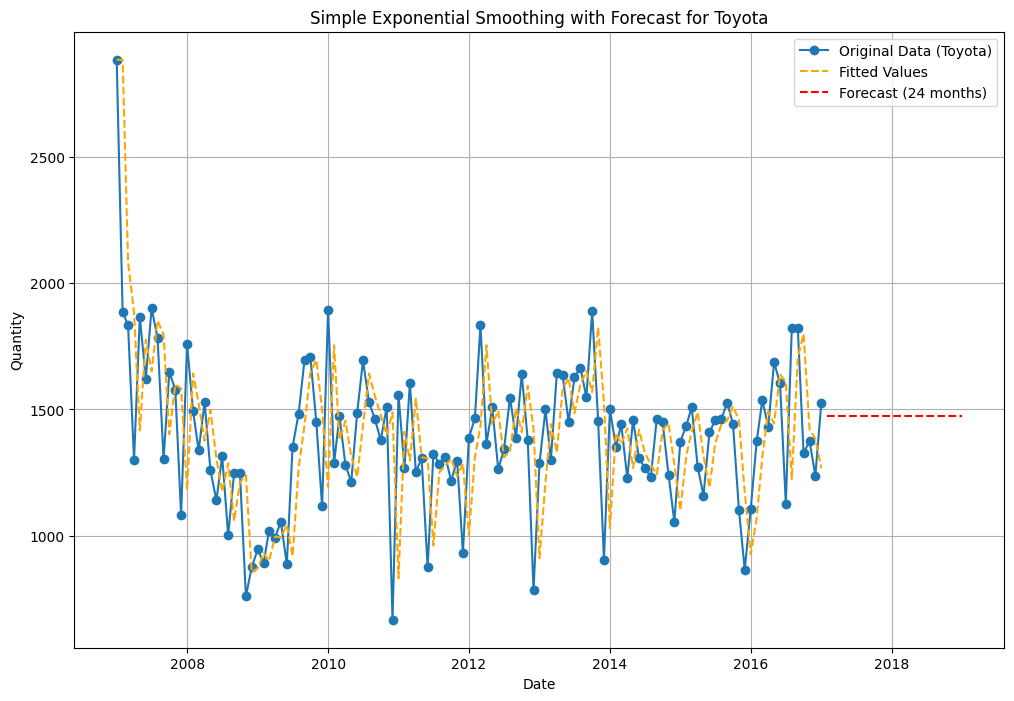

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Lọc dữ liệu cho Volkswagen
vw_data = df.query("Make == 'Toyota'").copy()
vw_data["ds"] = pd.to_datetime(vw_data["ds"])  # Đảm bảo cột ds là datetime
vw_data.set_index("ds", inplace=True)

# Fit the model
model = SimpleExpSmoothing(vw_data["Quantity"])
model_fit = model.fit(smoothing_level=0.8, optimized=False)  # optimized=False để tránh cảnh báo

# Lấy fitted values
vw_data["Fitted"] = model_fit.fittedvalues

# Dự báo thêm 24 tháng (2 năm)
forecast_steps = 24
forecast = model_fit.forecast(steps=forecast_steps)

# Tạo chỉ số thời gian cho forecast
last_date = vw_data.index[-1]
forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1),
                               periods=forecast_steps, freq="MS")
forecast_df = pd.DataFrame({"Forecast": forecast}, index=forecast_index)

# Plot dữ liệu gốc, fitted values, và forecast
plt.figure(figsize=(12, 8))
plt.plot(vw_data.index, vw_data["Quantity"], label="Original Data (Toyota)", marker="o")
plt.plot(vw_data.index, vw_data["Fitted"], label="Fitted Values", linestyle="--", color="orange")
plt.plot(forecast_df.index, forecast_df["Forecast"], label="Forecast (24 months)", linestyle="--", color="red")
plt.title("Simple Exponential Smoothing with Forecast for Toyota")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.grid()
plt.show()


## Kiểm tra lần nữa với hãng xe Volkswagen

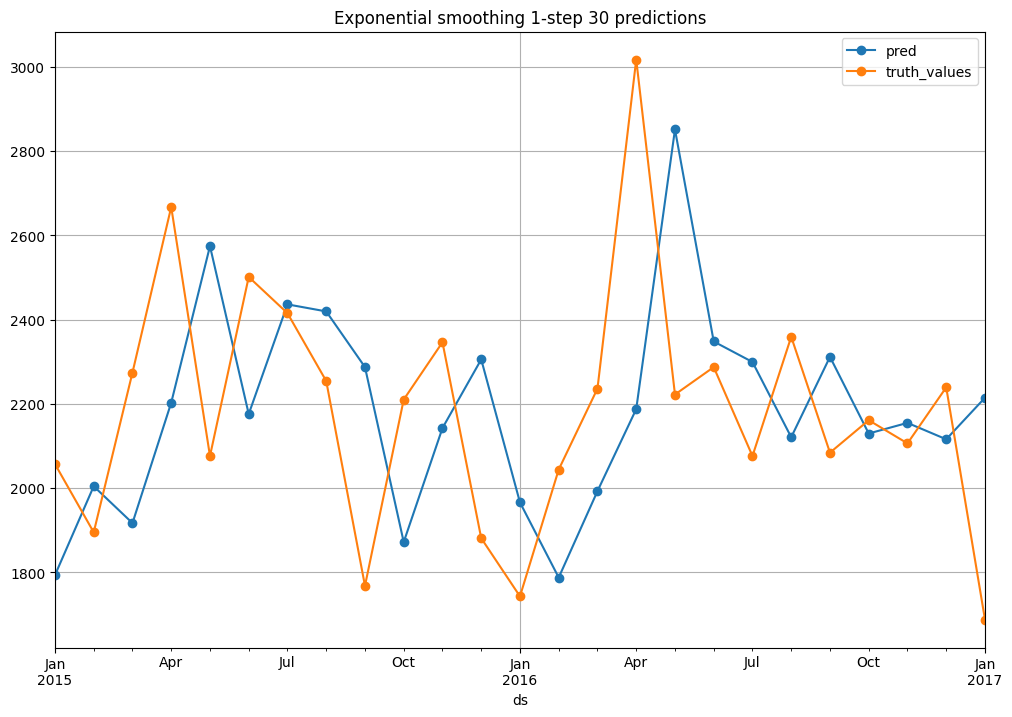

In [100]:
train = df.query("Make == 'Volkswagen'")[["ds", "Quantity"]]
test = df.query("Make == 'Volkswagen' & ds >= '2015-01-01'")[["ds", "Quantity"]]

history = train["Quantity"].tolist()
predictions = []
for new_obs in test['Quantity'].values:
    model = SimpleExpSmoothing(history)
    model_fit = model.fit(smoothing_level=0.8)
    prediction = model_fit.forecast(steps=1)
    predictions.append(prediction[0])
    history.append(new_obs)

result_data = np.array([predictions, test["Quantity"].tolist()]).T
result_df = pd.DataFrame(data=result_data, columns=["pred", "truth_values"])
result_df["ds"] = test.ds.reset_index(drop=True)
result_df.set_index("ds", inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
result_df.plot(ax=ax, marker="o")
plt.title("Exponential smoothing 1-step 30 predictions")
plt.grid()
plt.show()

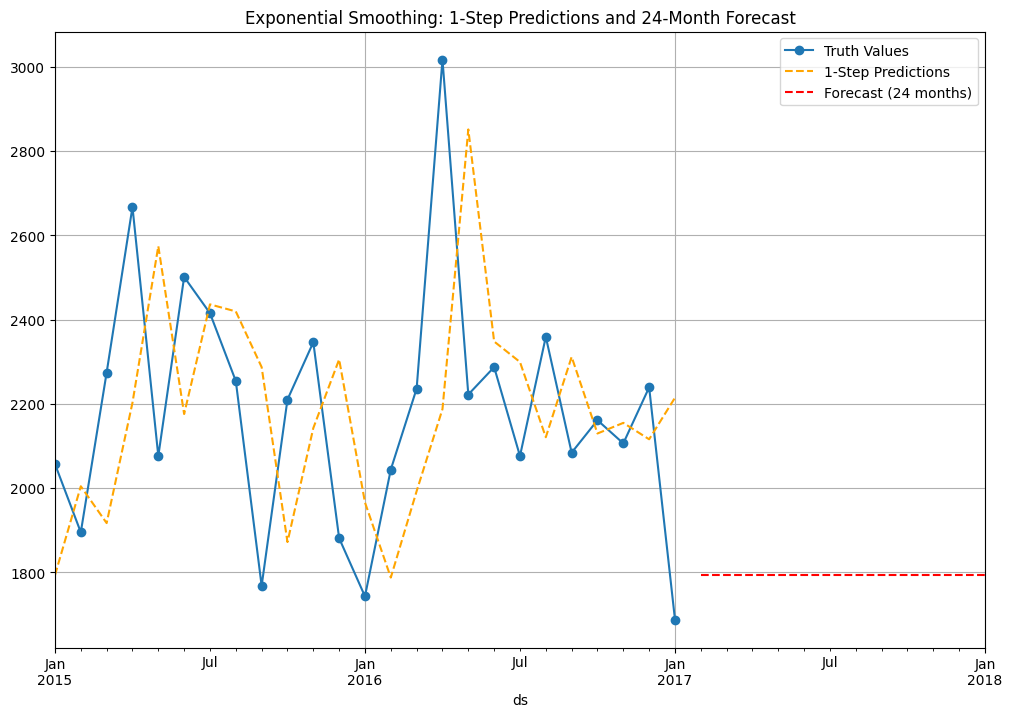

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

history = train["Quantity"].tolist()
predictions = []
for new_obs in test['Quantity'].values:
    model = SimpleExpSmoothing(history)
    model_fit = model.fit(smoothing_level=0.8)
    prediction = model_fit.forecast(steps=1)
    predictions.append(prediction[0])
    history.append(new_obs)
# Xây dựng DataFrame dự đoán 1 bước
result_data = np.array([predictions, test["Quantity"].tolist()]).T
result_df = pd.DataFrame(data=result_data, columns=["pred", "truth_values"])
result_df["ds"] = test["ds"].reset_index(drop=True)
result_df.set_index("ds", inplace=True)

# Dự báo dài hạn (24 tháng)
model = SimpleExpSmoothing(history)
model_fit = model.fit(smoothing_level=0.8)

forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)

# Tạo chuỗi thời gian cho dự báo
last_date = pd.to_datetime(test["ds"].iloc[-1])
forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1),
                               periods=forecast_steps, freq="MS")

forecast_df = pd.DataFrame({
    "forecast": forecast,
    "ds": forecast_index
})
forecast_df.set_index("ds", inplace=True)

# Kết hợp cả dự đoán 1 bước và dự báo dài hạn
combined_df = pd.concat([result_df, forecast_df], axis=0)
# Vẽ đồ thị
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
result_df["truth_values"].plot(ax=ax, marker="o", label="Truth Values")
result_df["pred"].plot(ax=ax, linestyle="--", color="orange", label="1-Step Predictions")
forecast_df["forecast"].plot(ax=ax, linestyle="--", color="red", label="Forecast (24 months)")
plt.title("Exponential Smoothing: 1-Step Predictions and 24-Month Forecast")
plt.grid()
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


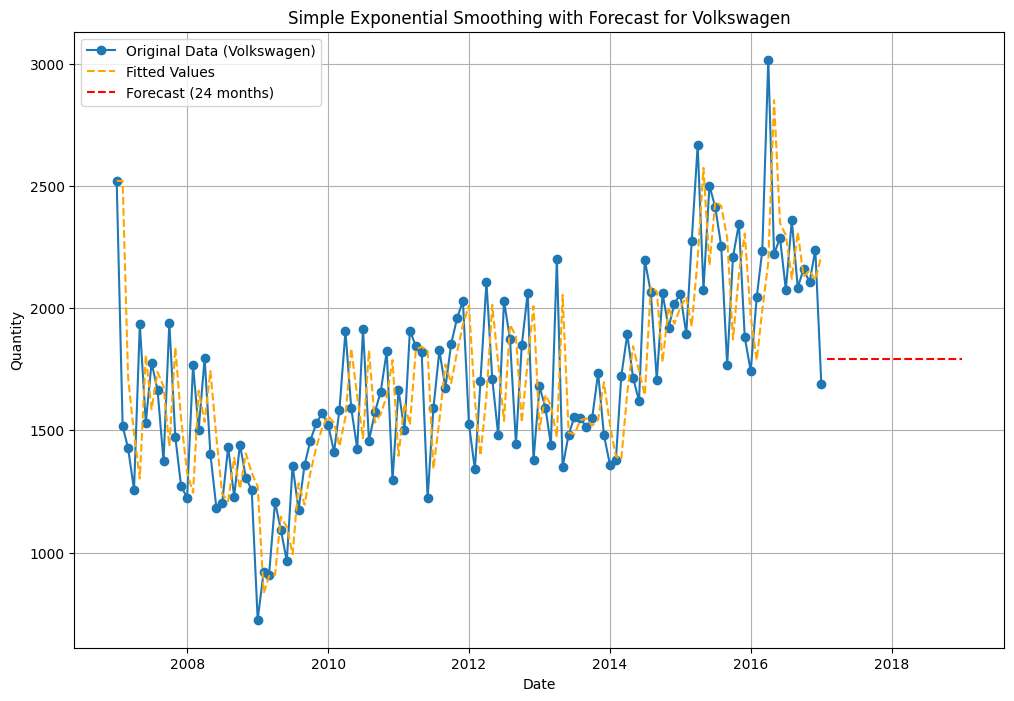

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Lọc dữ liệu cho Volkswagen
vw_data = df.query("Make == 'Volkswagen'").copy()
vw_data["ds"] = pd.to_datetime(vw_data["ds"])  # Đảm bảo cột ds là datetime
vw_data.set_index("ds", inplace=True)

# Fit the model
model = SimpleExpSmoothing(vw_data["Quantity"])
model_fit = model.fit(smoothing_level=0.8, optimized=False)  # optimized=False để tránh cảnh báo

# Lấy fitted values
vw_data["Fitted"] = model_fit.fittedvalues

# Dự báo thêm 24 tháng (2 năm)
forecast_steps = 24
forecast = model_fit.forecast(steps=forecast_steps)

# Tạo chỉ số thời gian cho forecast
last_date = vw_data.index[-1]
forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1),
                               periods=forecast_steps, freq="MS")
forecast_df = pd.DataFrame({"Forecast": forecast}, index=forecast_index)

# Plot dữ liệu gốc, fitted values, và forecast
plt.figure(figsize=(12, 8))
plt.plot(vw_data.index, vw_data["Quantity"], label="Original Data (Volkswagen)", marker="o")
plt.plot(vw_data.index, vw_data["Fitted"], label="Fitted Values", linestyle="--", color="orange")
plt.plot(forecast_df.index, forecast_df["Forecast"], label="Forecast (24 months)", linestyle="--", color="red")
plt.title("Simple Exponential Smoothing with Forecast for Volkswagen")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.grid()
plt.show()
